In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as OneHotEncoder
import datetime
import seaborn as sns
import sklearn.preprocessing as pp
from pyzipcode import ZipCodeDatabase

%load_ext autoreload
%autoreload 2
from functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import ticket sales data

In [4]:
df_tick = pd.DataFrame.from_csv('data/ticket_sales.csv', index_col = 0, parse_dates = True)

remove the zip codes that are nonsense, and remove the last 4 digits for the ones in the 33333-3333 format

^ means this is the begining of the string - nothing can come before it
() is one matching group 
\d{5} means 5 numerical digits
\- means that it contains a dash
? means the second matching group is optional
$ means that has to be the end of the string

`.str.extract()` is the pandas regular expression handler, and it makes columns out of regular expression matching groups

In [10]:
df_tick['zip_clean'] = df_tick.zip_code.str.extract('^(\d{5})(\-\d{4})?$').loc[:,0]

In [11]:
df_tick.head()

,zip_code,tickets,zip_clean
Date,,,
2014-10-31,3215,16,NaN
2014-10-31,3287,1,NaN
2014-10-31,3304,2,NaN
2014-10-31,12518,2,12518
2014-10-31,2095,1,NaN


#Call the zipcode database

In [37]:
zcdb = ZipCodeDatabase()

In [38]:
def convert_zip(zipcode):
    try:
        zipcode = zcdb[zipcode]
        return zipcode.state
    except:
        return np.nan

In [39]:
df_tick['state'] = df_tick.zip_clean.map(convert_zip)

In [40]:
df_tick.head()

,zip_code,tickets,zip_clean,state,is_CO,not_CO
Date,,,,,,
2014-10-31,3215,16,NaN,NaN,0,0
2014-10-31,3287,1,NaN,NaN,0,0
2014-10-31,3304,2,NaN,NaN,0,0
2014-10-31,12518,2,12518,NY,0,1
2014-10-31,2095,1,NaN,NaN,0,0


In [41]:
df_tick['is_CO'] = df_tick.state.map(lambda state: 1 if state == 'CO' else 0)
df_tick['not_CO'] = df_tick.state.map(lambda state: 1 if (state != 'CO' and not pd.isnull(state)) else 0)

In [42]:
df_tick.head()

,zip_code,tickets,zip_clean,state,is_CO,not_CO
Date,,,,,,
2014-10-31,3215,16,NaN,NaN,0,0
2014-10-31,3287,1,NaN,NaN,0,0
2014-10-31,3304,2,NaN,NaN,0,0
2014-10-31,12518,2,12518,NY,0,1
2014-10-31,2095,1,NaN,NaN,0,0


In [43]:
resamp_time = '1440Min'
df_tick_day = df_tick.resample(resamp_time, how = sum)

In [44]:
df_tick_day.head()

,tickets,is_CO,not_CO
Date,,,
2014-10-31,77,27,10
2014-11-01,64,14,21
2014-11-02,79,18,11
2014-11-03,35,9,10
2014-11-04,38,13,7


In [48]:
def plot_params():
    size = 18
    a = plt.rc('xtick', labelsize = size)
    b = plt.rc('ytick', labelsize = size)
    return a, b, plt.gca(), size

In [73]:
def plot_ticket_sales(df):
    plt.figure(facecolor='w', figsize = (15,20))
    a, b, axes, label_size = plot_params()

    ax1 = plt.subplot(311)
    df['tickets'].plot(marker = '.',linestyle = '-', label = 'Total Tickets Sold')
    plt.ylabel('Number of Tickets', size = label_size)
    plt.legend(fontsize = label_size)
    plt.xlabel('Date', size = label_size)

    ax2 = plt.subplot(312)
    df['is_CO'].plot(marker = '.',linestyle = '-', label = 'Sales to CO Residents')
    plt.ylabel('Number of Tickets', size = label_size)
    plt.legend(fontsize = label_size)
    plt.xlabel('Date', size = label_size)

    ax3 = plt.subplot(313)
    df['not_CO'].plot(marker = '.',linestyle = '-', label = 'Sales to Out-of-State Visitors')
    plt.ylabel('Number of Tickets', size = label_size)
    plt.legend(fontsize = label_size)
    plt.xlabel('Date', size = label_size)

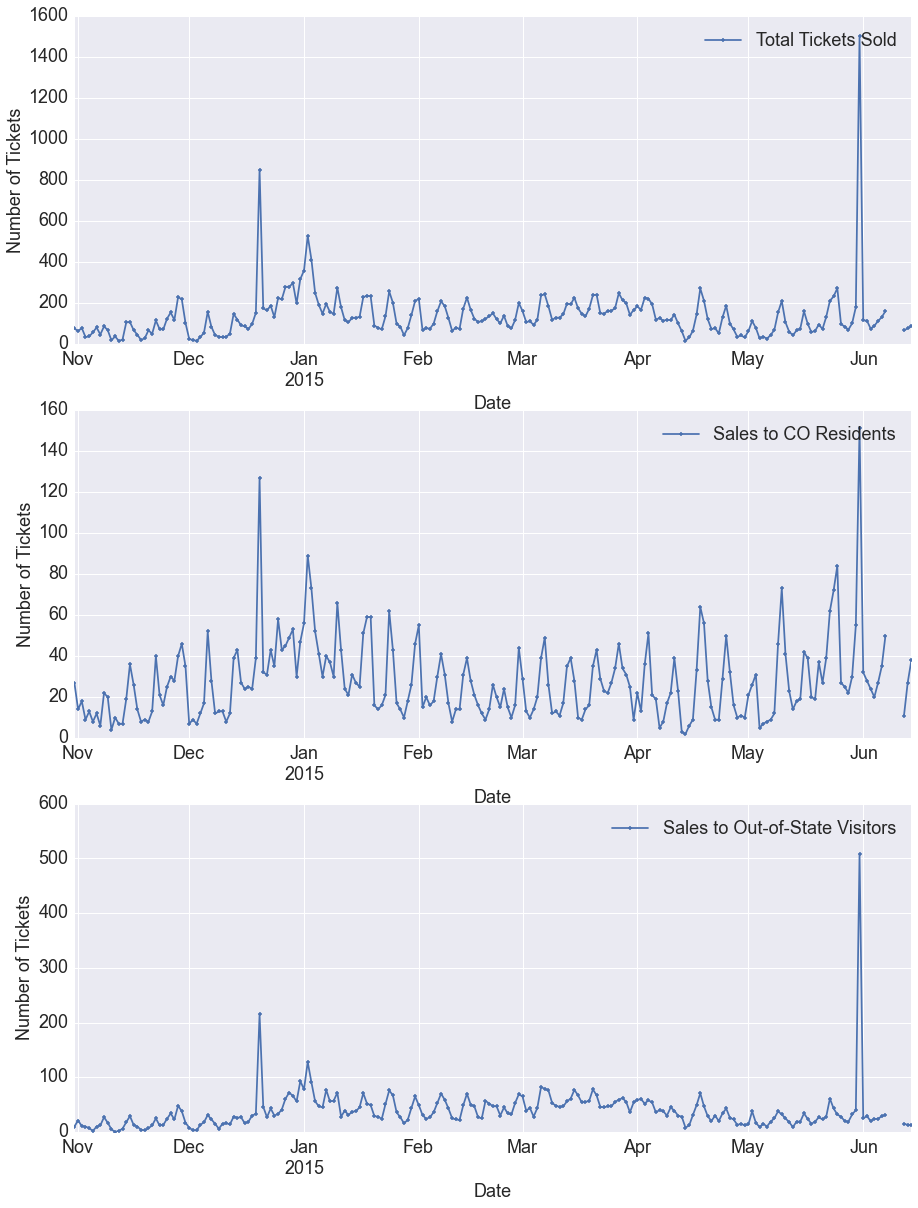

In [74]:
plot_ticket_sales(df_tick_day)

Import search volume data

In [75]:
df_search = pd.DataFrame.from_csv('data/search_vol.csv', index_col = 0, parse_dates = True)

Resample the data to one row per day and combine the two dataframes

In [76]:
resamp_time = '1440Min'
df_all_lift = pd.concat([df_tick_day, df_search], axis=1).dropna()

Create a "day of week" column.

In [77]:
day_of_week = []
for idx, day in df_all_lift.iterrows():
    day_of_week.append(idx.weekday())
    
df_all_lift['day_of_week'] = day_of_week

Create a list of features.

In [78]:
features = list(df_all_lift)

In [79]:
df_all_lift = df_all_lift.dropna()

In [80]:
def pp_standard_scaler(X):
    standard_scale = pp.StandardScaler()
    standard_scale_fit = standard_scale.fit(X)
    return standard_scale_fit.transform(X), standard_scale_fit

In [81]:
df_scaled_array, standard_scale_fit = pp_standard_scaler(df_all_lift)
df_scaled = pd.DataFrame(df_scaled_array, columns = features)
index_col = df.index
df_scaled.set_index(index_col, inplace = True)
#df_scaled = df_prescaled[features].apply(df_scaled_array)
df_sc = pd.concat([df_scaled, df[ref_column]], axis = 1) 

NameError: name 'df' is not defined

Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1290aba50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129646ed0>]], dtype=object)

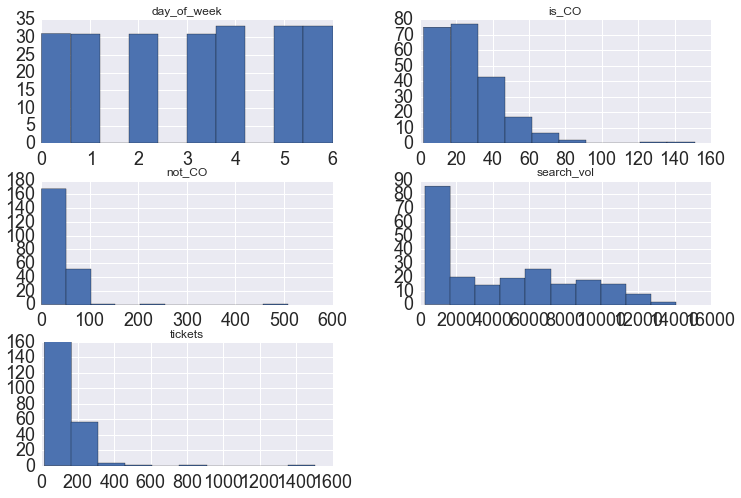

In [82]:
df_all_lift.hist()

Plot the site visit data.

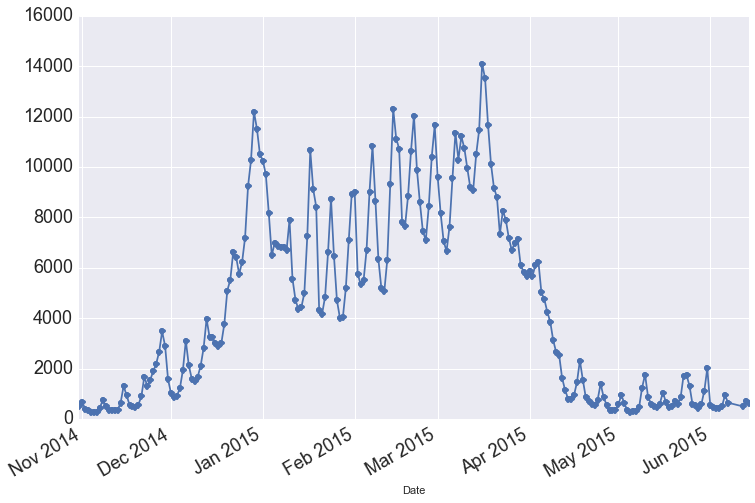

In [83]:
df_all_lift.search_vol.plot(marker = 'o')

Plot the ticket purchase data.

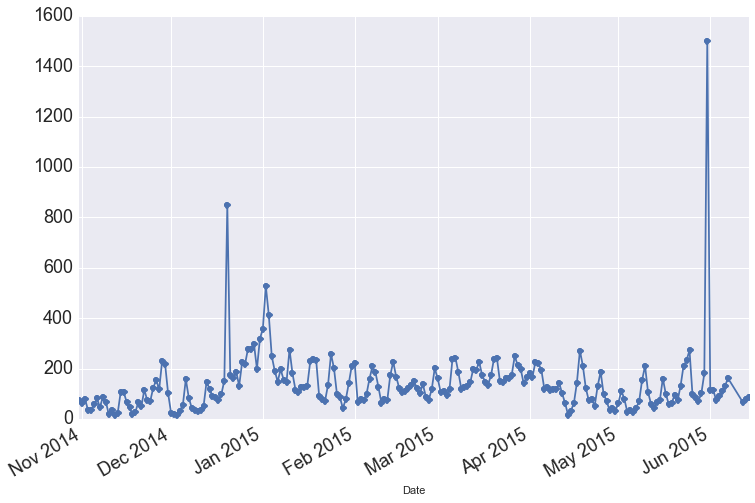

In [84]:
df_all_lift.tickets.plot(marker = 'o')

Look at the correlations between variables.

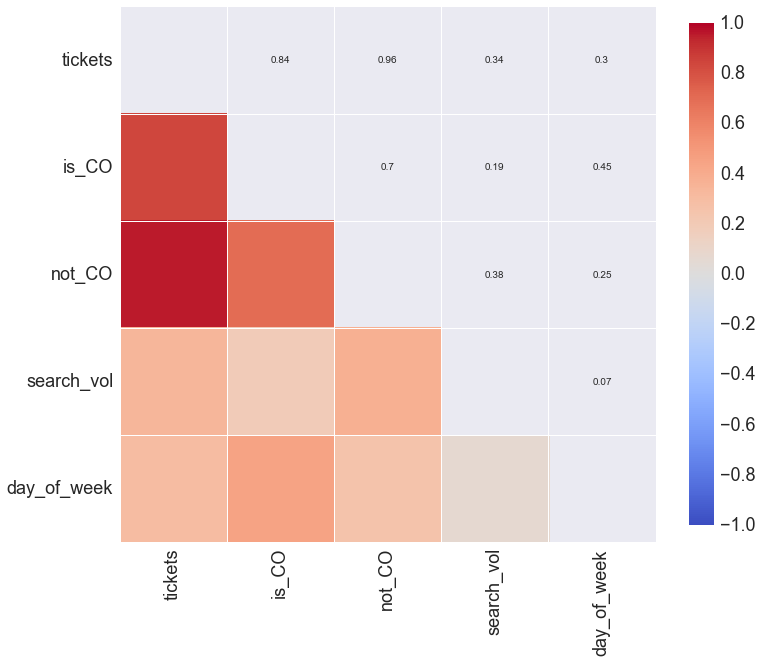

In [85]:
f, ax = plt.subplots(figsize=(12, 12))
sns.corrplot(df_all_lift, annot=True, sig_stars=False,
             diag_names=False, ax=ax)

Try shifting search volume back 1-7 days and make another correlation plot. 
IDEAS: 
1) Create features for area under search curve for different numbers of days/weeks before.
2) Create features for slope of for different numbers of days/weeks before. (How does this change with snow predictions)?
3) Create features combining searches and 

In [86]:
df_all_lift['shifted_search_1'] = df_all_lift.search_vol.shift(-1)
df_all_lift['shifted_search_2'] = df_all_lift.search_vol.shift(-2)
df_all_lift['shifted_search_3'] = df_all_lift.search_vol.shift(-3)
df_all_lift['shifted_search_4'] = df_all_lift.search_vol.shift(-4)
df_all_lift['shifted_search_5'] = df_all_lift.search_vol.shift(-5)
df_all_lift['shifted_search_6'] = df_all_lift.search_vol.shift(-6)
df_all_lift['shifted_search_7'] = df_all_lift.search_vol.shift(-7)

In [87]:
df_all_lift.head()

,tickets,is_CO,not_CO,search_vol,day_of_week,shifted_search_1,shifted_search_2,shifted_search_3,shifted_search_4,shifted_search_5,shifted_search_6,shifted_search_7
Date,,,,,,,,,,,,
2014-10-31,77,27,10,509,4,683,419,341,292,281,301,453
2014-11-01,64,14,21,683,5,419,341,292,281,301,453,771
2014-11-02,79,18,11,419,6,341,292,281,301,453,771,520
2014-11-03,35,9,10,341,0,292,281,301,453,771,520,371
2014-11-04,38,13,7,292,1,281,301,453,771,520,371,346


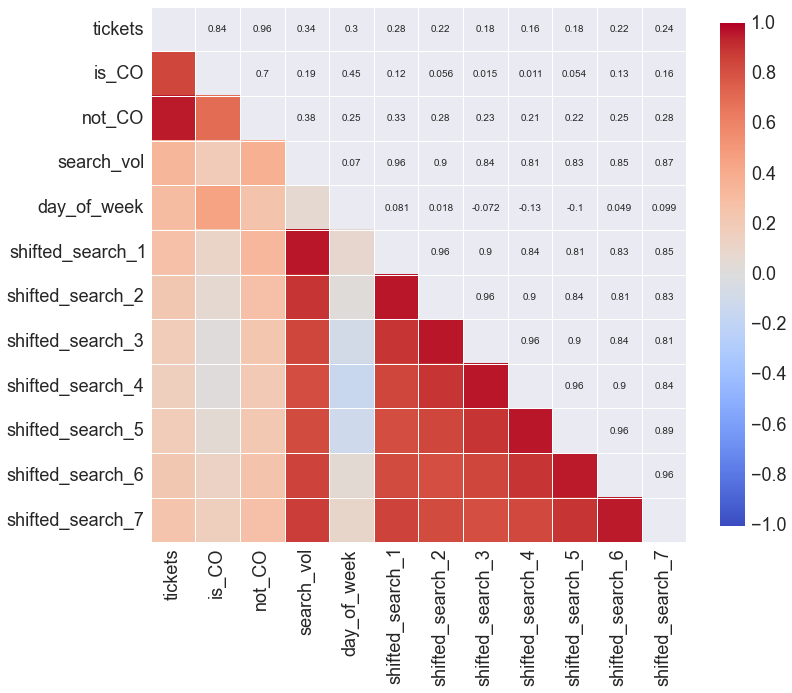

In [88]:
f, ax = plt.subplots(figsize=(12, 12))
sns.corrplot(df_all_lift, annot=True, sig_stars=False,
             diag_names=False, ax=ax)

The plot above shows day-of searches to be a stronger predictor of ticket sales than the days before, which is not what I expected. Are lots of locals looking at the site on good ski days? Do lots of people but tickets the day of, or is this just a coincidence based on the fact that more people ski on the weekends and also have time to look at tickets on the weekends? 

In [89]:
df_all_lift['search*day'] = df_all_lift.search_vol * df_all_lift.day_of_week

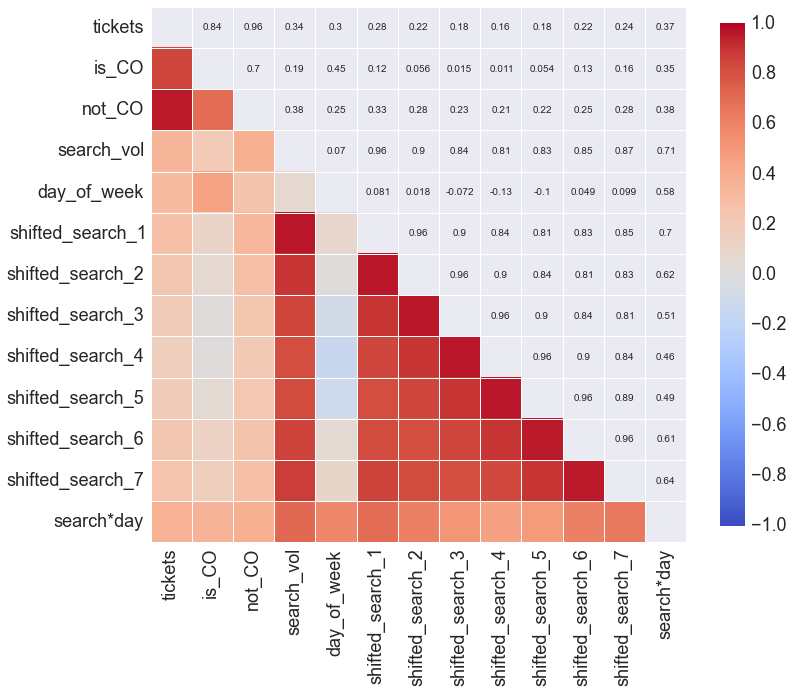

In [90]:
f, ax = plt.subplots(figsize=(12, 12))
sns.corrplot(df_all_lift, annot=True, sig_stars=False,
             diag_names=False, ax=ax)